In [83]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pylab as plt


In [84]:
'''
    Dataset
'''
class Dataset():
    def __init__(self, df=None):
        self.items = []
        if df:
            self.add(df)

    def add_df(self, df, source=None):
        items = []
        for row in df[['id', 'subject', 'terms']].values:
            id = row[0]
            subject = row[1]
            terms = [t.strip() for t in row[2].split(',')]
            items.append([source, id, subject, terms])
        self.items.extend(items)

    def add_fn(self, name, fn, columns):
        df = pd.read_csv(fn, sep='\t')
        ds = pd.DataFrame(df[columns].values, columns=['id', 'subject', 'terms'])
        ds.drop_duplicates(['subject', 'terms'], inplace=True)
        ds.dropna(inplace=True)
        self.add_df(ds, name)
        
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx]


In [85]:
'''
    Evaluators
'''
import os
import json
import requests

class Evaluator():
    def __init__(self):
        pass

    def eval(self, id, terms):
        pass

'''
    Phen2GeneEval
'''
PHEN2GENE_URL = 'https://f29bio.northeurope.cloudapp.azure.com/api/Phen2Gene/calc?weightModel=sk'

class Phen2GeneEval():
    def __init__(self, url=PHEN2GENE_URL, rows=100):
        self.url = url + F'&rows={rows}'

    def request(self, source, id, hpos):
        source = source or 'common'
        fn = F'_cache/{source}-{id}.json'
        if os.path.isfile(fn):
            with open(fn, 'r') as fp:
                return json.load(fp)
        resp = requests.post(self.url, json=hpos)
        with open(fn, 'w') as fp:
            json.dump(resp.json(), fp, indent=2)
        return resp.json()

    def validate(self, source, id, subject, terms):
        subject = subject.upper()
        resp = self.request(source, id, terms)
        query = resp['query']
        for term in query:
            status = query[term]['status']
            if status != 'ok':
                print(source, id, term, status, sep='\t')

    def eval(self, source, id, subject, terms):
        subject = subject.upper()
        resp = self.request(source, id, terms)
        ranking = resp['response']
        for item in ranking:
            if item.upper() == subject:
                return ranking[subject]['rank']
        return 1000

'''
    PhenolyzerEval
'''
class PhenolyzerEval():
    def __init__(self):
        pass

    def eval(self, source, id, subject, terms):
        fn = os.path.join('_phenolyzer', source, F'{id}.json')
        with open(fn, 'r') as fp:
            ranking = json.load(fp)
        subject = subject.upper()
        n = 1
        for item in ranking:
            if item['Name'].upper() == subject:
                return n
            n += 1
        return 1000
    

In [86]:
'''
    Load Dataset
'''
dataset = Dataset()

dataset.add_fn('rao', '_data/rao-testCases_rarediseases_full.tsv', ['Internal ID', 'Gene', 'Clinical Indication and Phenotype (HPO)'])
dataset.add_fn('kleyner', '_data/kleyner-testCases_rarediseases_full.tsv', ['Internal ID', 'Gene', 'Clinical Indication and Phenotype (HPO)'])
dataset.add_fn('cipriani', '_data/cipriani-cases.tsv', ['Patient_identifier', 'Gene', 'Clinical_diagnosis_label'])

for row in list(dataset)[:4]:
    print(*row, sep='\t')
    

rao	TCS001	EP300	['HP:0010301', 'HP:0000252', 'HP:0001263']
rao	TCS003	SMARCB1	['HP:0001263', 'HP:0002650', 'HP:0001382', 'HP:0002079', 'HP:0001999']
rao	TCS004	LARP7	['HP:0001263', 'HP:0004322', 'HP:0100255']
rao	TCS005	KAT6B	['HP:0007105']


In [87]:
'''
    Plot
'''
def plot(d, title=None):
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    y = np.cumsum(y)
    if title:
        fig = plt.figure()
        fig.suptitle(title)
        plt.plot(x, y)
        return fig
    else:
        return plt.plot(x, y)
    

{1: 7, 2: 9, 3: 6, 4: 5, 5: 6, 6: 4, 7: 2, 8: 4, 9: 4, 10: 2, 11: 3, 12: 2, 13: 2, 14: 2, 15: 4, 16: 6, 17: 1, 18: 1, 19: 4, 20: 1, 21: 1, 22: 3, 23: 1, 24: 1, 25: 236}


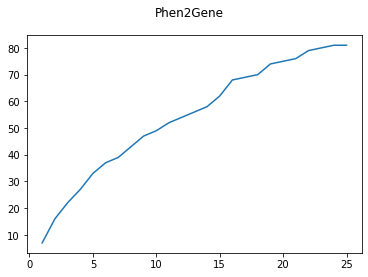

In [88]:
'''
    Eval Phen2Gene
'''
phen2gene = Phen2GeneEval()

ranking1 = {n + 1: 0 for n in range(25)}
for source, id, subject, terms in dataset:
    rank = phen2gene.eval(source, id, subject, terms)
    if rank > 25:
        rank = 25
    ranking1[rank] += 1

print(ranking1)

ranking1[25] = 0

plot(ranking1, 'Phen2Gene')
plt.show()


{1: 7, 2: 1, 3: 9, 4: 6, 5: 4, 6: 7, 7: 4, 8: 4, 9: 1, 10: 2, 11: 0, 12: 1, 13: 0, 14: 4, 15: 2, 16: 2, 17: 1, 18: 2, 19: 0, 20: 1, 21: 1, 22: 3, 23: 3, 24: 1, 25: 251}


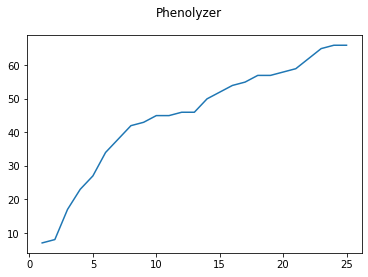

In [89]:
'''
    Eval Phenolyzer
'''
phenolyzer = PhenolyzerEval()

ranking2 = {n + 1: 0 for n in range(25)}
for source, id, subject, terms in dataset:
    rank = phenolyzer.eval(source, id, subject, terms)
    if rank > 25:
        rank = 25
    ranking2[rank] += 1

print(ranking2)

ranking2[25] = 0
    
plot(ranking2, 'Phenolyzer')
plt.show()


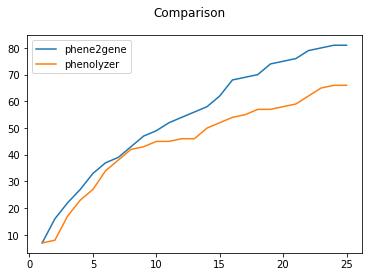

In [90]:
fig = plt.figure()
fig.suptitle('Comparison')
a, = plot(ranking1)
b, = plot(ranking2)
plt.legend([a, b], ['phen2gene', 'phenolyzer'])
